<a href="https://colab.research.google.com/github/MercyMoparthy/lab-lora-tuning-peft/blob/main/lab-lora-tuning-peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

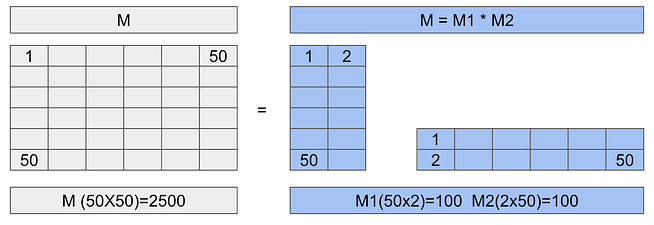

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [2]:
import importlib

def check_version(lib_name):
    try:
        lib = importlib.import_module(lib_name)
        version = getattr(lib, '__version__', '❓ Version not found')
        print(f"{lib_name}: ✅ Installed, version {version}")
    except ImportError:
        print(f"{lib_name}: ❌ Not installed")

check_version("peft")
check_version("datasets")
check_version("ipywidgets")

peft: ✅ Installed, version 0.8.2
datasets: ✅ Installed, version 2.16.1
ipywidgets: ✅ Installed, version 7.7.5


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [4]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [5]:
#Inference original model
input_sentences = tokenizer("Can you give me some advice to stay motivated when I'm tired?", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


["Can you give me some advice to stay motivated when I'm tired?"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

In [6]:
#Inference original model
input_sentences = tokenizer("The meaning of life is?", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['The meaning of life is? The answer to this question depends on the context. In a world where there are no rules, it may be that we have an infinite number and variety in our lives.\nIn fact if you look at your daily routine or work schedule then most people will']


# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [7]:
from datasets import load_dataset

# Clear cache workaround
!rm -r ~/.cache/huggingface/datasets

# Load/Reload
dataset = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset)

# Tokenize the "prompt" column
data = data.map(lambda samples: tokenizer(samples["prompt"], padding=True, truncation=True), batched=True)

train_sample = data["train"].select(range(50))
train_sample = train_sample.remove_columns('act')

display(train_sample)

rm: cannot remove '/root/.cache/huggingface/datasets': No such file or directory


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [8]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

# Fine-Tuning.
First is necesary create a LoRA config.


In [9]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [10]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [11]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [12]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [13]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mercy-sneha (mercy-sneha-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


Step,Training Loss


TrainOutput(global_step=14, training_loss=2.7967420305524553, metrics={'train_runtime': 912.1443, 'train_samples_per_second': 0.11, 'train_steps_per_second': 0.015, 'total_flos': 77008581427200.0, 'train_loss': 2.7967420305524553, 'epoch': 2.0})

In [14]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [15]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [16]:
input_sentences = tokenizer("Can you give me some advice to stay motivated when I'm tired?", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['Can you give me some advice to stay motivated when I\'m tired? I will ask for your help in order not only making decisions but also finding ways of improving my performance. My first request is "I need a way that helps improve productivity while still being effective at doing something else".\nMy second and third requests are "']


In [17]:
input_sentences = tokenizer("As a motivational coach, can you give me a training program", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['As a motivational coach, can you give me a training program that will help people achieve their goals. I would suggest some exercises and strategies to use in order for them reach those results or even better yet they could also be used as an exercise plan which helps the person improve on certain aspects of fitness such as: strength']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

## Switching to LLaMA (e.g. TinyLlama-1.1B)
* Prepare Dataset from TinyLlama--1.1B

In [18]:
from datasets import load_dataset

# Load dataset
dataset = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset)

# Re-tokenize the prompt column with the resized TinyLLaMA tokenizer
data = data.map(
    lambda samples: tokenizer(samples["prompt"], padding=True, truncation=True),
    batched=True
)

# Select a small training sample for speed (optional)
train_sample = data["train"].select(range(203))
#train_sample = data["train"].select(range(50)) #attempt with a small range gave bad outputs

# Remove unused columns if present
if "act" in train_sample.column_names:
    train_sample = train_sample.remove_columns("act")

display(train_sample)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 203
})

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Set pad_token if not already set (optional safety check)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model
foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto"
)

# Resize model embeddings to match tokenizer
foundation_model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(32000, 2048)

In [20]:
print("Tokenizer length:", len(tokenizer))
print("Model vocab size:", foundation_model.get_input_embeddings().num_embeddings)
print("Pad token ID:", tokenizer.pad_token_id)

Tokenizer length: 32000
Model vocab size: 32000
Pad token ID: 2


## Fine Tuning

In [21]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # typical for LLaMA/TinyLlama
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.10229075496156657
None


In [22]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In [23]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=False
)

## Model Training

In [26]:
import os
from google.colab import userdata
os.environ["WANDB_API_KEY"]= userdata.get('WANDB_API_KEY')
# passes secret to wandb

In [28]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [30]:
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True # Set to True to force CPU training
)

In [32]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Set pad_token if not already set (optional safety check)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model and explicitly move it to CPU
foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    # device_map="auto" # Remove device_map="auto"
).to("cpu") # Explicitly move to CPU

# Resize model embeddings to match tokenizer
foundation_model.resize_token_embeddings(len(tokenizer))

Embedding(32000, 2048)

In [ ]:
#Save the model.
peft_model_tinyllama_path  = os.path.join(output_directory, f"lora_model_tinyllama")

trainer.model.save_pretrained(peft_model_tinyllama_path )

In [ ]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_tinyllama_path,
                                        is_trainable=False)

## Fine-Tune Model

In [ ]:
input_sentences = tokenizer(
    "Can you give me some advice to stay motivated when I'm tired?",
    return_tensors="pt"
)

# Move input to same device as model
input_sentences = {k: v.to(loaded_model.device) for k, v in input_sentences.items()}

# Run generation
foundational_outputs_sentence = get_outputs(
    loaded_model,
    input_sentences,
    max_new_tokens=50
)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

In [ ]:
input_sentences = tokenizer(
    "Can you give me some advice to stay motivated when I'm tired?",
    return_tensors="pt"
)

# Move input to same device as model
input_sentences = {k: v.to(loaded_model.device) for k, v in input_sentences.items()}

# Run generation
foundational_outputs_sentence = get_outputs(
    loaded_model,
    input_sentences,
    max_new_tokens=50
)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

In [ ]:
input_sentences = tokenizer(
    "Act as a motivational coach. Can you give me some advice to stay motivated when I'm tired?",
    return_tensors="pt"
)

# Move input to same device as model
input_sentences = {k: v.to(loaded_model.device) for k, v in input_sentences.items()}

# Run generation
foundational_outputs_sentence = get_outputs(
    loaded_model,
    input_sentences,
    max_new_tokens=50
)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

## Observation
### **What Could Improve It**
- Use filtered or task-specific prompts (e.g., "act" == 'Motivational coach')
- Increase dataset size to at least 1,000–2,000 examples
- Train for more epochs (5+)
- Add validation set or W&B logging to monitor learning
- Try alternative prompt strategies or instruction formatting


### **Conclusion**
Despite the lack of strong results, this lab demonstrated:
- How to fine-tune a large model efficiently with LoRA
- How to tokenize, train, save, and infer with a Hugging Face + PEFT pipeline
- The importance of prompt design and training data quality in low-resource instruction tuning

It was a meaningful exploration, and a solid foundation for scaling future experiments.